# First approach: no preprocessing

In this first approach, we will not preprocess the data and we will use all the features available. We are going to train 4 different models with the following hyperparameters:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


**Index**

- [Data loading](#Data-loading)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading

In this approach, we will not preprocess the data and all the models will be trained with the raw data. To evaluate the models, we will use a **10-fold cross-validation** instead of splitting the data into training and test sets. By doing this, we will be able to compare the models in a more robust way and reduce the dependence on the randomness of the data split.

Regarding to the metrics used to evaluate the models, we will use the **accuracy**, **precision**, **recall** and **f1-score**. The reason to not use only the accuracy is that the dataset is unbalanced and the accuracy can be misleading.


In [1]:
using DataFrames
using CSV
using Serialization

In [2]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 1 method)

In [3]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame)
data[1:5, :]

Row,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,Father's occupation,Displaced,Educational special needs,Debtor,Tuition fees up to date,Gender,Scholarship holder,Age at enrollment,International,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Float64,String15
1,1,8,5,2,1,1,1,13,10,6,10,1,0,0,1,1,0,20,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,10.8,1.4,1.74,Dropout
2,1,6,1,11,1,1,1,1,3,4,4,1,0,0,0,1,0,19,0,0,6,6,6,14.0,0,0,6,6,6,13.6667,0,13.9,-0.3,0.79,Graduate
3,1,1,5,5,1,1,1,22,27,10,10,1,0,0,0,1,0,19,0,0,6,0,0,0.0,0,0,6,0,0,0.0,0,10.8,1.4,1.74,Dropout
4,1,8,2,15,1,1,1,23,27,6,4,1,0,0,1,0,0,20,0,0,6,8,6,13.4286,0,0,6,10,5,12.4,0,9.4,-0.8,-3.12,Graduate
5,2,12,1,3,0,1,1,22,28,10,10,0,0,0,1,0,0,45,0,0,6,9,5,12.3333,0,0,6,6,6,13.0,0,13.9,-0.3,0.79,Graduate


In [4]:
# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [5]:
inputs = Float32.(Matrix(inputs))

# Define the categories and their mapping
label_mapping = Dict("Dropout" => 0, "Graduate" => 1, "Enrolled" => 2)

# Encode the targets
targets_label_encoded = [label_mapping[label] for label in targets]

println("Encoded targets: ", targets_label_encoded[1:5])

# To decode later, create a reverse mapping
reverse_mapping = Dict(v => k for (k, v) in label_mapping)
decoded_targets = [reverse_mapping[code] for code in targets_label_encoded]

println("Decoded targets: ", decoded_targets[1:5])

# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

Encoded targets: [0, 1, 0, 1, 1]
Decoded targets: ["Dropout", "Graduate", "Dropout", "Graduate", "Graduate"]


## Individual models


### ANN

We are going to use the our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 10 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [74]:
# Set the random seed for reproducibility
Random.seed!(42)

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeromean,
    verbose=false
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.8419 ± 0.00432
	Class 1: 0.86544 ± 0.0061
	Class 2: 0.83245 ± 0.00877
	Class 3: 0.82607 ± 0.00963
Mean precision: 0.74381 ± 0.00833
	Class 1: 0.8029 ± 0.01124
	Class 2: 0.78325 ± 0.00679
	Class 3: 0.52838 ± 0.04551
Mean recall: 0.76198 ± 0.00702
	Class 1: 0.77053 ± 0.01488
	Class 2: 0.91874 ± 0.01047
	Class 3: 0.3106 ± 0.01675
Mean f1_score: 0.74481 ± 0.00653
	Class 1: 0.78623 ± 0.01017
	Class 2: 0.84558 ± 0.00829
	Class 3: 0.39036 ± 0.0232
Training ANN with topology: [32]
Mean accuracy: 0.84577 ± 0.00548
	Class 1: 0.86888 ± 0.00651
	Class 2: 0.8372 ± 0.00948
	Class 3: 0.82828 ± 0.01021
Mean precision: 0.75093 ± 0.0098
	Class 1: 0.81468 ± 0.01138
	Class 2: 0.78685 ± 0.00755
	Class 3: 0.53692 ± 0.04616
Mean recall: 0.76718 ± 0.00868
	Class 1: 0.76624 ± 0.01669
	Class 2: 0.9244 ± 0.01084
	Class 3: 0.33149 ± 0.01796
Mean f1_score: 0.75157 ± 0.0084
	Class 1: 0.7896 ± 0.01126
	Class 2: 0.85008 ± 0.00887
	Class 3: 0.40945 ± 0.02529
Training A

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [14]:
max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeromean,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435 ± 0.03155
	Class 2: 0.8255 ± 0.0243
	Class 3: 0.81939 ± 0.02309
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793 ± 0.06498
	Class 2: 0.73257 ± 0.16399
	Class 3: 0.53936 ± 0.16781
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915 ± 0.13539
	Class 2: 0.72364 ± 0.19998
	Class 3: 0.41 ± 0.18145
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132 ± 0.04483
	Class 2: 0.71912 ± 0.15232
	Class 3: 0.45831 ± 0.17659
Training DT model with max_depth: 5
Mean accuracy: 0.83213 ± 0.0088
	Class 1: 0.8309 ± 0.03625
	Class 2: 0.84788 ± 0.02588
	Class 3: 0.82617 ± 0.00918
Mean precision: 0.74631 ± 0.01206
	Class 1: 0.79043 ± 0.07879
	Class 2: 0.82461 ± 0.06194
	Class 3: 0.52825 ± 0.04957
Mean recall: 0.75248 ± 0.01102
	Class 1: 0.85111 ± 0.15039
	Class 2: 0.78786 ± 0.134
	Class 3: 0.31725 ± 0.0773
Mean f1_score: 0.73401 ± 0.01651
	Class 1: 0.80702 ± 0.03569
	Class 2: 0.79643 ± 0.03926
	Class 3: 0.39173 ± 0.0634
Trainin

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [67]:
kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeromean,
    verbose=false
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.84533 ± 0.00495
	Class 1: 0.85149 ± 0.02272
	Class 2: 0.84992 ± 0.01902
	Class 3: 0.83296 ± 0.02312
Mean precision: 0.757 ± 0.01058
	Class 1: 0.80906 ± 0.04621
	Class 2: 0.77219 ± 0.09231
	Class 3: 0.57944 ± 0.15552
Mean recall: 0.76718 ± 0.00889
	Class 1: 0.85899 ± 0.11589
	Class 2: 0.74109 ± 0.2184
	Class 3: 0.42795 ± 0.16891
Mean f1_score: 0.75375 ± 0.00859
	Class 1: 0.82706 ± 0.03354
	Class 2: 0.7474 ± 0.15216
	Class 3: 0.4907 ± 0.16587
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.84641 ± 0.0041
	Class 1: 0.85375 ± 0.02102
	Class 2: 0.84947 ± 0.01614
	Class 3: 0.83205 ± 0.01899
Mean precision: 0.75631 ± 0.00704
	Class 1: 0.80972 ± 0.0392
	Class 2: 0.76785 ± 0.09913
	Class 3: 0.57601 ± 0.14185
Mean recall: 0.76763 ± 0.00686
	Class 1: 0.86141 ± 0.10833
	Class 2: 0.73355 ± 0.22684
	Class 3: 0.43873 ± 0.16576
Mean f1_score: 0.75469 ± 0.00641
	Class 1: 0.82964 ± 0.03288
	Class 2: 0.7417 ± 0.164
	Cla

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [18]:
n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeromean,
        verbose=false
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77705 ± 0.00679
	Class 1: 0.78909 ± 0.02929
	Class 2: 0.77941 ± 0.03501
	Class 3: 0.7751 ± 0.01603
Mean precision: 0.66848 ± 0.01216
	Class 1: 0.73354 ± 0.01955
	Class 2: 0.6505 ± 0.19042
	Class 3: 0.4542 ± 0.15361
Mean recall: 0.6718 ± 0.01153
	Class 1: 0.70836 ± 0.08313
	Class 2: 0.64326 ± 0.20925
	Class 3: 0.45158 ± 0.19295
Mean f1_score: 0.66855 ± 0.01181
	Class 1: 0.71881 ± 0.04481
	Class 2: 0.64532 ± 0.19601
	Class 3: 0.45225 ± 0.17255
Training KNN model with n_neighbors: 3
Mean accuracy: 0.78771 ± 0.00867
	Class 1: 0.78819 ± 0.02181
	Class 2: 0.78865 ± 0.02324
	Class 3: 0.80244 ± 0.01201
Mean precision: 0.6678 ± 0.01512
	Class 1: 0.72659 ± 0.02441
	Class 2: 0.70936 ± 0.02084
	Class 3: 0.4185 ± 0.05345
Mean recall: 0.68964 ± 0.01251
	Class 1: 0.78408 ± 0.07667
	Class 2: 0.75432 ± 0.07526
	Class 3: 0.25816 ± 0.04078
Mean f1_score: 0.67362 ± 0.0135
	Class 1: 0.75353 ± 0.04834
	Class 2: 0.73042 ± 0.04599
	Class 3: 0.31883 ± 0.0

### Save the results

In order to be able to compare the results of the models without running the training again, we will save the results in a dictionary. The dictionary will have the following structure:

```julia
{
    :model: {
        'num_trained_models': int,
        'parameters': Dict{String, Any},
        'general_results': [
            {
                'accuracy': AbstractVector{Float64},
                'precision': AbstractVector{Float64},
                'recall': AbstractVector{Float64},
                'f1_score': AbstractVector{Float64},
            },
            ... # One element for each trained model
        ],
        'class_results': [
            [
                {
                    'accuracy': AbstractVector{Float64},
                    'precision': AbstractVector{Float64},
                    'recall': AbstractVector{Float64},
                    'f1_score': AbstractVector{Float64},
                },
                ... # One element for each class
            ],
            ... # One element for each trained model
        ]
    }
}
```

The results of all approaches will be avaiable in the `results` dictionary. The filename with the results of individual models of this first approach will be `1_individual_results.jl`.


In [76]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "1_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [6]:
results_folder = "results/"
filename = results_folder * "1_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end

# As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 6

Model 1: max_depth: 3, 
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915
	Class 2: 0.72364
	Class 3: 0.41
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132
	Class 2: 0.71912
	Class 3: 0.45831
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793
	Class 2: 0.73257
	Class 3: 0.53936
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435
	Class 2: 0.8255
	Class 3: 0.81939

Model 2: max_depth: 5, 
Mean recall: 0.75248 ± 0.01102
	Class 1: 0.85111
	Class 2: 0.78786
	Class 3: 0.31725
Mean f1_score: 0.73401 ± 0.01651
	Class 1: 0.80702
	Class 2: 0.79643
	Class 3: 0.39173
Mean precision: 0.74631 ± 0.01206
	Class 1: 0.79043
	Class 2: 0.82461
	Class 3: 0.52825
Mean accuracy: 0.83213 ± 0.0088
	Class 1: 0.8309
	Class 2: 0.84788
	Class 3: 0.82617

Model 3: max_depth: 10, 
Mean recall: 0.72943 ± 0.00853
	Class 1: 0.80219
	Class 2: 0.76494
	Class 3: 0.41181
Mean f1_score: 0.72579 ± 0.00793
	Class 1: 0.79454
	Class 2: 0.77063
	Class 3: 0.42524
Mean precision: 0.7251 ±

### Conclusions

# Plot here the mean of the four metrics to compare and extract the best model and make a comparison or some comments


In [7]:
# Aggregate metrics
model_names, metrics, metric_means, metric_stds = aggregateMetrics(loaded_obj)

(Any["DT", "KNN", "SVM", "ANN"], [:accuracy, :precision, :recall, :f1_score], Dict{Symbol, Vector{Any}}(:recall => [0.7196346889411434, 0.7040014389073066, 0.7266993830059022, 0.7669252416229188], :f1_score => [0.7144292232116937, 0.6839208800399996, 0.7046867762214709, 0.7508035179406778], :precision => [0.7187705227476738, 0.6893932346822501, 0.7173086870180971, 0.7497410357920287], :accuracy => [0.8135622972827735, 0.7970607557820131, 0.8144344423909016, 0.8458159038371662]), Dict{Symbol, Vector{Any}}(:recall => [0.024291538163931606, 0.015699362596867307, 0.041827443557401194, 0.0031608933109135776], :f1_score => [0.017097664088217963, 0.008689510682422732, 0.0502069663392245, 0.004851486269343011], :precision => [0.020106589314725355, 0.014466605758843044, 0.036385704666208614, 0.0049548846573992285], :accuracy => [0.01502874950912389, 0.009660064916970836, 0.032308951549032815, 0.0025476679372455806]))

In [8]:
# Plot metrics for each algorithm
plotMetricsPerAlgorithm(loaded_obj, output_dir="./plots/")

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.


In [9]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │ 0.832127 │  0.746314 │  0.75248 │ 0.734008 │
│      max_depth: 10 │ 0.821882 │  0.725103 │ 0.729432 │ 0.725794 │
│       max_depth: 3 │ 0.822393 │  0.732543 │ 0.734622 │ 0.722908 │
│      max_depth: 15 │ 0.812703 │  0.715533 │ 0.716545 │ 0.715731 │
│      max_depth: 20 │  0.79996 │  0.700824 │ 0.697563 │ 0.698881 │
│ max_depth: nothing │ 0.792309 │  0.692307 │ 0.687165 │ 0.689253 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├─────

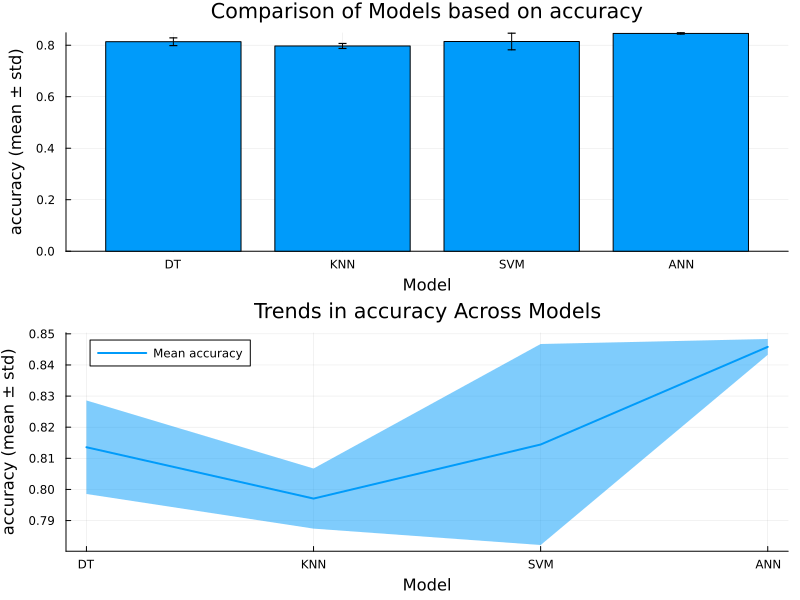

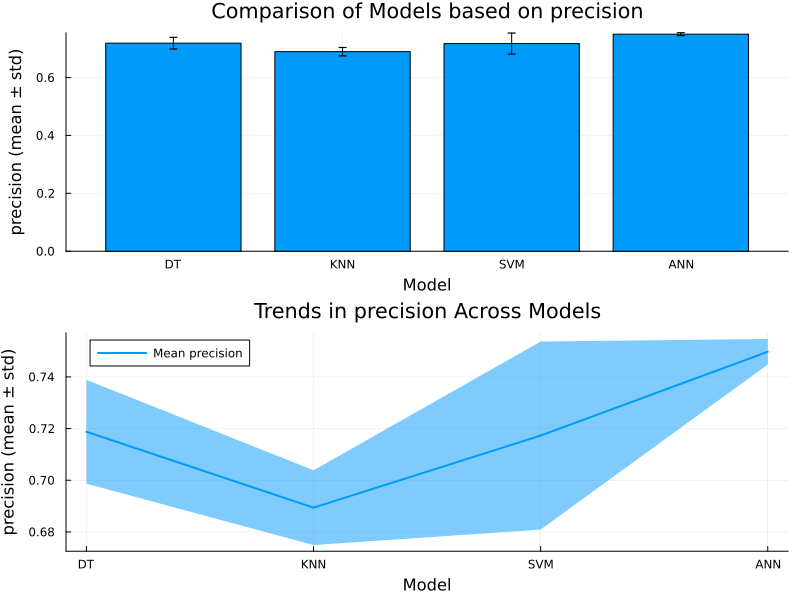

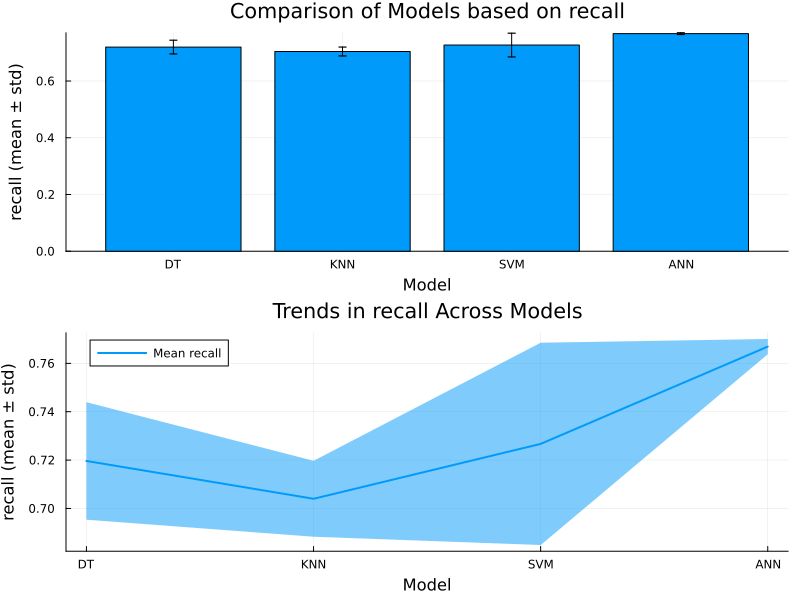

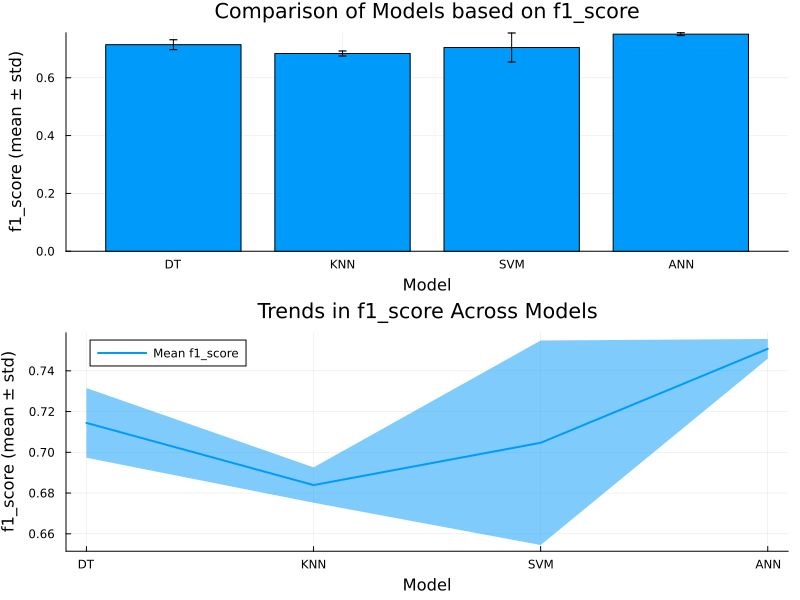

In [10]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/", show=true)

In [11]:
# Generate and print the overall comparison table
generateComparisonTable(model_names, metrics, metric_means, metric_stds; sort_by=:f1_score, rev=true)


Comparison of Metrics Across Models (Sorted by f1_score):
┌───────┬───────────────┬───────────────┬───────────────┬───────────────┐
│ Model │      Accuracy │     Precision │        Recall │      F1-Score │
├───────┼───────────────┼───────────────┼───────────────┼───────────────┤
│   ANN │ 0.846 ± 0.003 │  0.75 ± 0.005 │ 0.767 ± 0.003 │ 0.751 ± 0.005 │
│    DT │ 0.814 ± 0.015 │  0.719 ± 0.02 │  0.72 ± 0.024 │ 0.714 ± 0.017 │
│   SVM │ 0.814 ± 0.032 │ 0.717 ± 0.036 │ 0.727 ± 0.042 │  0.705 ± 0.05 │
│   KNN │  0.797 ± 0.01 │ 0.689 ± 0.014 │ 0.704 ± 0.016 │ 0.684 ± 0.009 │
└───────┴───────────────┴───────────────┴───────────────┴───────────────┘


The **Artificial Neural Network (ANN)** stands out as the best-performing model, with its `[64, 32]` topology achieving an accuracy of 85.0% and an F1-score of 75.9%. The overall metrics table confirms its superiority, with the highest accuracy (84.6% ± 0.3%), precision (75.0% ± 0.5%), recall (76.7% ± 0.3%), and F1-score (75.1% ± 0.5%). Larger architectures like `[64, 64]` show diminishing returns, indicating the `[64, 32]` setup balances complexity and performance.

The **Support Vector Machine (SVM)** performs well with `C: 10.0, kernel: linear`, achieving 84.7% accuracy and 75.6% F1-score. Its precision (71.7% ± 3.6%) and recall (72.7% ± 4.2%) make it a strong alternative to ANN. Linear kernels outperform others, demonstrating the dataset’s compatibility with linear decision boundaries.

The **K-Nearest Neighbors (KNN)** model achieves stable but lower performance, with `n_neighbors: 11` providing 80.5% accuracy and a 69.1% F1-score. The metrics table confirms KNN’s weaker results, with an accuracy of 79.7% ± 1.0%.

The **Decision Tree (DT)** performs best with `max_depth: 5`, achieving 83.2% accuracy and a 73.4% F1-score. As depth increases, performance declines due to overfitting. The metrics table positions DT alongside SVM in accuracy (81.4% ± 1.5%) but slightly lower in precision and recall.

## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)
